In [3]:
%matplotlib inline 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import Bio
from Bio.pairwise2 import format_alignment
import copy

import seaborn as sns 
sns.set_style('ticks');
current_color = sns.color_palette();
sns.set_palette('Set2');

#import plotsettings 
#publishable = plotsettings.Set('Cell') 

# Adjust all text and axes colors to black. default is some studip gray that appears to faint when printed 
from matplotlib import rc , rcParams
rc('axes',edgecolor='black')
rc('xtick',color='black',labelsize=15)
rc('ytick',color='black',labelsize=15)
rc('text',color='black')
rc('axes',labelcolor='black',linewidth=2.0)
rc('font',size=15)
#rcParams["patch.force_edgecolor"] = True

# Loading the data

In [4]:
#filename = 'cas9-target-d-replicate-1-delta-abas.txt'
#filename = 'cas9-target-e-replicate-1-delta-abas.txt'
#filename = 'cas12a-target-d-replicate-1-delta-abas.txt'
filename = 'cas12a-target-d-replicate-2-delta-abas.txt'

Path = '../data_ABA_Finkelsteinlab/champ-cas9-cas12a-data/'
#Cas='Cas9'
Cas = 'Cas12a'

data = pd.read_table(Path+filename, skiprows=3)
on_target = (pd.read_table(Path+filename, skiprows=1, nrows=1).columns.values[0]).split(' ')[4]
data_name = pd.read_table(Path+filename, nrows=1).columns.values[0][2:]
data.rename(columns={'# Sequence': 'Sequence'}, inplace=True)

# Data processing

In [5]:
def separate_PAM(S, Cas='Cas9'):
    
    if Cas == 'Cas9':
        PAM_len =3
        PAM = S[-PAM_len:]
        s = S[0:-PAM_len]
        s = s[::-1]
        s = s[0:-4]
        canonical = False
        if PAM[1:]=='GG':
            canonical = True
    if Cas == 'Cas12a':
        PAM_len = 4
        PAM = S[:PAM_len]
        s = S[PAM_len:]
        s = s[0:-3]
        canonical = False
        if (PAM[:3]=='TTT')&(PAM[3]!='T'):
            canonical = True
    return PAM, s, canonical

def find_length_diff(S, on_target, Cas='Cas9'):
    
    _, s, _ = separate_PAM(S, Cas)
    _, t, _ = separate_PAM(on_target, Cas='Cas9')
    return len(s)-len(t)

def Allign(S, on_target, Cas):
    
    _, s, _ = separate_PAM(S, Cas)
    _, t, _ = separate_PAM(on_target, Cas)
    A = Bio.pairwise2.align.globalxx(t, s)
    if len(s)==len(t):
        MM_num = np.sum(np.array(list(t))==np.array(list(s)))
        a = (t,s,MM_num,0,len(t))
        if a not in A:
            A.append(a)
    
    return A

In [6]:
data['On Target'] = data['Sequence'] == on_target
data['PAM'] = data['Sequence'].apply(lambda S: separate_PAM(S, Cas)[0])
data['Canonical'] = data['Sequence'].apply(lambda S: separate_PAM(S, Cas)[2])
data['Length difference'] = data['Sequence'].apply(lambda S: find_length_diff(S, on_target, Cas))
data['Alignment_raw'] = data['Sequence'].apply(lambda S: Allign(S, on_target, Cas))

In [7]:
def Clean_allignment(x):
    A = copy.deepcopy(x['Alignment_raw'])
    Length_diff = x['Length difference']

    if Length_diff == 0:
        function_to_filter = lambda a: not(('-' in a[0]) or ('-' in a[1]))
        A = filter(function_to_filter, A)
        return A
    
    if Length_diff > 0:
        function_to_filter = lambda a: not(('-' not in a[0]) or ('-' in a[1]))
        A = filter(function_to_filter, A)
        id_for_sort = lambda a: '|'.join(map(lambda x: str(x), list(np.arange(1,len(a[0])+1)[np.array(list(a[0])) != np.array(list(a[1]))])))
        if len(A)>1:        
            A.sort(key=id_for_sort, reverse=True)
            del A[1:]
        return(A)
    
    if Length_diff < 0:
        function_to_filter = lambda a: not(('-' in a[0]) or ('-' not in a[1]))
        A = filter(function_to_filter, A)
        id_for_sort = lambda a: '|'.join(map(lambda x: str(x), list(np.arange(1,len(a[0])+1)[np.array(list(a[0])) != np.array(list(a[1]))])))
        if len(A)>1:        
            A.sort(key=id_for_sort, reverse=True)
            del A[1:]
        return(A)



In [8]:
data['Alignment_selected'] = data.apply(Clean_allignment, axis=1)
data['Alignment'] = data['Alignment_selected'].apply(lambda A: format_alignment(*A[0]).split('S')[0] if len(A) > 0 else '')
data['Alignment (All)'] = data['Alignment_raw'].apply(lambda A: ('\n').join(map(lambda a: format_alignment(*a).split('S')[0], A)) if len(A)>0 else '')

In [9]:
def Make_Mutation_ID(x):
    
    if len(x['Alignment_selected']) == 0:
        return ''
    
    Length_diff = x['Length difference']
    a = x['Alignment_selected'][0]

    if Length_diff > 0:
        ta = np.array(list(a[0]))
        sa = np.array(list(a[1]))
        All_positions = np.arange(1,len(sa)+1)
        Mut_positions_on_s = All_positions[ta!=sa]
        Mut_Seqs = sa[[ta!=sa]]
        Mut_types = np.array(['i']*len(Mut_Seqs))
        Mut_Seqs_on_t = ta[[ta!=sa]]
        Mut_types[Mut_Seqs_on_t!='-'] = 'r'
        offset = np.zeros(len(Mut_types), dtype=int)
        for n in range(len(offset)):
            offset[n] = np.sum(Mut_types[0:n]=='i')
        # For insertion it gives the position of a base on the target before which there is an insertion.
        Mut_positions = Mut_positions_on_s - offset 
        ID_list = []
        for Mut_type, Mut_pos, Mut_Seq in zip(Mut_types, Mut_positions, Mut_Seqs):
            ID_list.append(':'.join([Mut_type, str(Mut_pos), Mut_Seq]))
        ID_list = filter(lambda x: 'i:21' not in x[:-2], ID_list) # Insertion after position 20 does not count.
        ID = '|'.join(ID_list)

    if Length_diff < 0:
        ta = np.array(list(a[0]))
        sa = np.array(list(a[1]))
        All_positions = np.arange(1,len(ta)+1)
        Mut_positions = All_positions[ta!=sa]
        Mut_Seqs = ta[[ta!=sa]]
        Mut_types = np.array(['d']*len(Mut_Seqs))
        Mut_Seqs_on_s = sa[[ta!=sa]]
        Mut_types[Mut_Seqs_on_s!='-'] = 'r'
        ID_list = []
        for Mut_type, Mut_pos, Mut_Seq in zip(Mut_types, Mut_positions, Mut_Seqs):
            ID_list.append(':'.join([Mut_type, str(Mut_pos), Mut_Seq]))
        ID = '|'.join(ID_list)

    if Length_diff == 0:
        ta = np.array(list(a[0]))
        sa = np.array(list(a[1]))
        All_positions = np.arange(1,len(ta)+1)
        Mut_positions = All_positions[ta!=sa]
        Mut_Seqs = sa[[ta!=sa]]
        Mut_types = np.array(['r']*len(Mut_Seqs))
        ID_list = []
        for Mut_type, Mut_pos, Mut_Seq in zip(Mut_types, Mut_positions, Mut_Seqs):
            ID_list.append(':'.join([Mut_type, str(Mut_pos), Mut_Seq]))
        ID = '|'.join(ID_list)
    
    return ID

In [10]:
data['Mutation ID'] = data.apply(Make_Mutation_ID, axis=1)
data['Mutation Type'] = data['Mutation ID'].apply(lambda x: '|'.join(map(lambda y: y[0], x.split('|'))) if x!='' else '')
data['Mutation Count'] = data['Mutation Type'].apply(lambda x: len(x.split('|')) if x!='' else np.NaN)

In [11]:
data = data[['Sequence', 'On Target', 'PAM', 'Canonical', 'Length difference', 'Alignment', 'Alignment (All)', 
             'Mutation ID', 'Mutation Type', 'Mutation Count', 'Delta ABA (kBT)', 'Uncertainty']]

output_filename = filename.split('.')[0]+'-'+'processed'+'.csv'
data.to_csv(Path+output_filename, index=False)
data.head()


,Sequence,On Target,PAM,Canonical,Length difference,Alignment,Alignment (All),Mutation ID,Mutation Type,Mutation Count,Delta ABA (kBT),Uncertainty
0,TGTTAGTGATAAGTGGAATGCCATGTAGG,False,TGTT,False,2,-GTGATAAGTGGAATGCCATG-\n |||||||||||||||||||| ...,-GTGATAAGTGGAATGCCATG-\n |||||||||||||||||||| ...,i:1:A,i,1.0,1.891984,0.085287
1,TTTAGTGATATGTAGAATGCCATGTGG,False,TTTA,True,0,GTGATAAGTGGAATGCCATG\n||||||.||.||||||||||\nGT...,GTGATAAGTG--GAATGCCATG\n||||| | || ||||||||||...,r:7:T|r:10:A,r|r,2.0,2.093878,0.162121
2,TTGAGTGATAAGTGGAATGTCATGTGG,False,TTGA,False,0,GTGATAAGTGGAATGCCATG\n|||||||||||||||.||||\nGT...,GTGATAAGTGGAATGC-CATG\n||||||||||||||| ||||\n...,r:16:T,r,1.0,3.896490,0.091545
3,TTTAGTGATAAGCTGGTAATGCCATGTGG,False,TTTA,True,2,GTGATAAG-TGG-AATGCCATG\n|||||||| ||| |||||||||...,GTGATAAG-TGG-AATGCCATG\n|||||||| ||| |||||||||...,i:9:C|i:12:T,i|i,2.0,2.410795,0.144076
4,TAATCACTATTCACCTATGCCATGTGG,False,TAAT,False,0,GTGATAAGTGGAATGCCATG\n............||||||||\nCA...,GTG-A-TAAGTGG--A---ATGCCATG\n | | | | | ...,r:1:C|r:2:A|r:3:C|r:4:T|r:5:A|r:6:T|r:7:T|r:8:...,r|r|r|r|r|r|r|r|r|r|r|r,12.0,3.551005,0.096792


# Analysis

## 1. Single Mutation

In [12]:
def plot_single_mut_ABA(data, Mut_type, data_name='Finkelstein Data', Canonical=True):

    Mut_names = {'r':'Mismatch', 'i':'Insertion', 'd': 'Deletion'}
    Mut_name = Mut_names[Mut_type]
    
    single_mut_data = data[(data['Canonical']==Canonical)&(data['Mutation Type']==Mut_type)][['Mutation ID', 'Delta ABA (kBT)', 'Uncertainty']]
    single_mut_data['Position'] = single_mut_data['Mutation ID'].apply(lambda x: int(x.split(':')[1]))
    single_mut_data_mean = single_mut_data[['Position', 'Delta ABA (kBT)', 'Uncertainty']].groupby('Position').mean().reset_index()
        
    single_mut_data_mean.plot(x='Position', y='Delta ABA (kBT)',yerr='Uncertainty', marker='o', linewidth=1, color='blue') 
    plt.xlabel(Mut_name+' postion', fontsize=15)
    plt.ylabel('$\Delta$ABA', fontsize=15)
    plt.title(data_name,fontsize=15)
    if not Canonical:
        plt.title(data_name + ' - Noncanonical',fontsize=15)
    
    return single_mut_data_mean

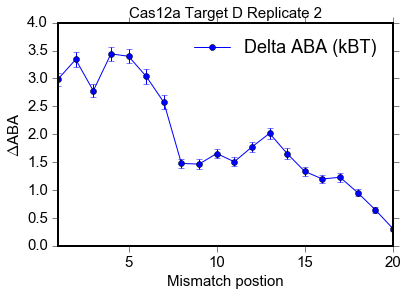

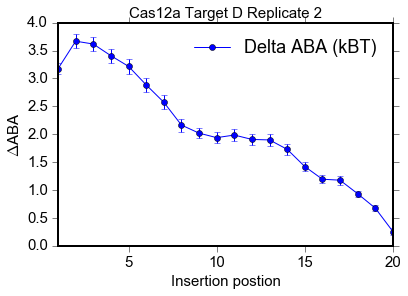

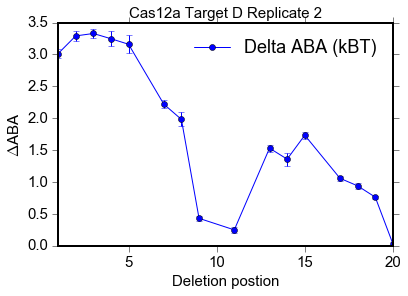

In [13]:
Mut_type = 'r'
_ = plot_single_mut_ABA(data, Mut_type, data_name)
Mut_type = 'i'
_ = plot_single_mut_ABA(data, Mut_type, data_name)
Mut_type = 'd'
_ = plot_single_mut_ABA(data, Mut_type, data_name)

### Noncanonical PAM

C:\Users\behro\Anaconda2\lib\site-packages\matplotlib\axes\_base.py:2787: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1.0, right=1.0
  'left=%s, right=%s') % (left, right))
C:\Users\behro\Anaconda2\lib\site-packages\matplotlib\axes\_base.py:2787: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1.0, right=1.0
  'left=%s, right=%s') % (left, right))


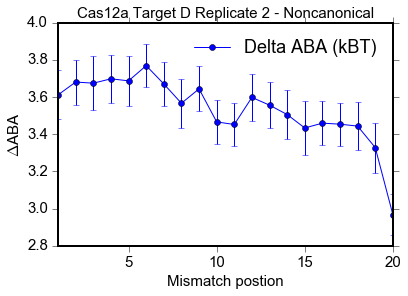

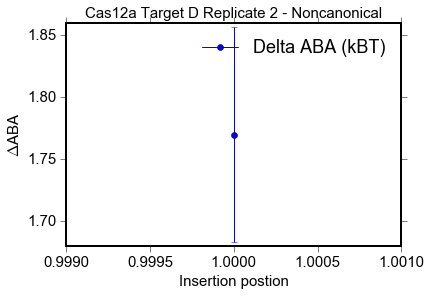

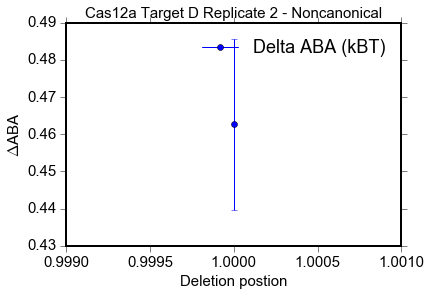

In [14]:
Mut_type = 'r'
_ = plot_single_mut_ABA(data, Mut_type, data_name, Canonical=False)
Mut_type = 'i'
_ = plot_single_mut_ABA(data, Mut_type, data_name, Canonical=False)
Mut_type = 'd'
_ = plot_single_mut_ABA(data, Mut_type, data_name, Canonical=False)

## 2. Double Mutations

In [15]:
def plot_double_mut_ABA(data, Mut_type, data_name='Finkelstein Data', Canonical=True):
    
    Mut_names = {'r':'Mismatch', 'i':'Insertion', 'd': 'Deletion'}
    Mut_name = Mut_names[Mut_type]
    Mut_type_str = Mut_type+'|'+Mut_type

    double_mut_data = data[(data['Canonical']==Canonical)&(data['Mutation Type']==Mut_type_str)][['Mutation ID', 'Delta ABA (kBT)', 'Uncertainty']]
    double_mut_data['Position'] = double_mut_data['Mutation ID'].apply(lambda x: '|'.join(map(lambda y: y.split(':')[1], x.split('|'))))
    double_mut_data_mean = double_mut_data[['Position', 'Delta ABA (kBT)', 'Uncertainty']].groupby('Position').mean().reset_index()

    Ng = 20;
    double_mut_map = np.empty((Ng,Ng))
    double_mut_map[:] = np.nan
    for n in range(len(double_mut_data_mean)):
        pos = double_mut_data_mean['Position'].iloc[n]
        Positions = map(lambda x: int(x)-1, pos.split('|'))
        double_mut_map[Positions[1],Positions[0]] = double_mut_data_mean['Delta ABA (kBT)'].iloc[n]
        
    plt.figure()
    sns.heatmap(double_mut_map, cmap='coolwarm',cbar=True,vmin=0,vmax=double_mut_data_mean['Delta ABA (kBT)'].max())
    plt.xlabel(Mut_name+' 1', fontsize=15)
    plt.ylabel(Mut_name+' 2', fontsize=15)
    plt.title('$\Delta$ABA - '+data_name,fontsize=15)
    if not Canonical:
        plt.title('$\Delta$ABA - '+data_name+' - Noncanonical',fontsize=15)
    ax = plt.gca()
    ax.set_xticklabels(map(lambda x: str(int(x)),ax.get_xticks()+0.5));
    ax.set_yticklabels(map(lambda x: str(int(x)),ax.get_yticks()+0.5));
    
    return double_mut_data_mean, double_mut_map

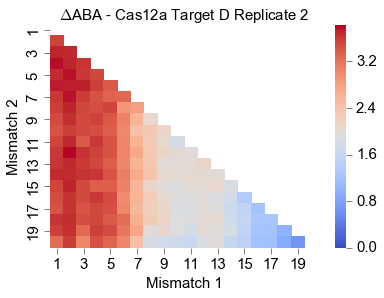

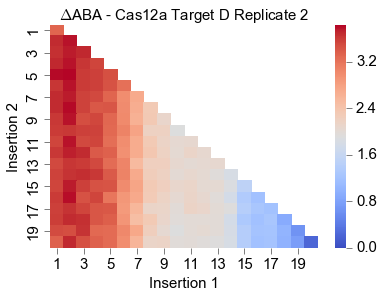

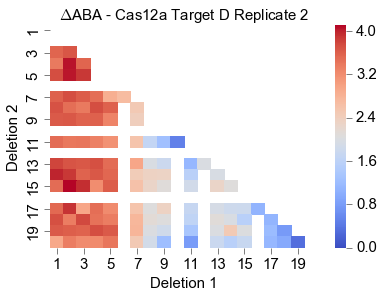

In [16]:
Mut_type = 'r'
_,_, = plot_double_mut_ABA(data, Mut_type, data_name)
Mut_type = 'i'
_,_, = plot_double_mut_ABA(data, Mut_type, data_name)
Mut_type = 'd'
_,_, = plot_double_mut_ABA(data, Mut_type, data_name)

### Noncanonical PAM

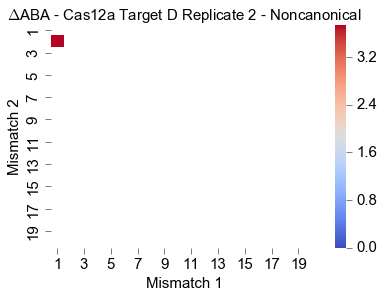

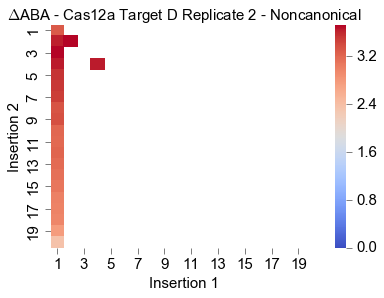

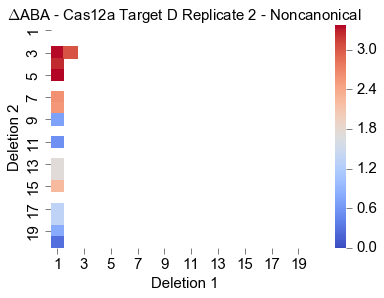

In [17]:
Mut_type = 'r'
_,_, = plot_double_mut_ABA(data, Mut_type, data_name, Canonical=False)
Mut_type = 'i'
_,_, = plot_double_mut_ABA(data, Mut_type, data_name, Canonical=False)
Mut_type = 'd'
_,_, = plot_double_mut_ABA(data, Mut_type, data_name, Canonical=False)

## 3. Blocks of Mismatches

In [18]:
def make_block_ID(MM_pos_list):
    
    bi = MM_pos_list[0]
    bf = MM_pos_list[-1]
    block = np.arange(bi,bf+1)
    if (len(block)!=len(MM_pos_list)) or np.any(block!=np.array(MM_pos_list)):
        return ''
    return '|'.join(map(str, [bi, bf]))

In [19]:
def plot_block_mm_ABA(data, data_name='Finkelstein Data', Canonical=True):
    
    select_multi_mm = data['Mutation Type'].apply(lambda x: np.unique(np.array(x.split('|')))[0]=='r')
    multi_mm_data = data[(data['Canonical']==Canonical)&(select_multi_mm)&(data['Mutation Count']>2)][['Mutation ID', 'Delta ABA (kBT)', 'Uncertainty']]
    multi_mm_data['MM Positions'] = multi_mm_data['Mutation ID'].apply(lambda x: map(lambda y: int(y.split(':')[1]), x.split('|')))
    multi_mm_data['Position'] = multi_mm_data['MM Positions'].apply(make_block_ID)
    multi_mm_data = multi_mm_data[(multi_mm_data['Position']!='')]
    block_mm_data_mean = multi_mm_data[['Position', 'Delta ABA (kBT)', 'Uncertainty']].groupby('Position').mean().reset_index()

    Ng = 20;
    block_mm_map = np.empty((Ng,Ng))
    block_mm_map[:] = np.nan
    for n in range(len(block_mm_data_mean)):
        pos = block_mm_data_mean['Position'].iloc[n]
        Positions = map(lambda x: int(x)-1, pos.split('|'))
        block_mm_map[Positions[0],Positions[1]] = block_mm_data_mean['Delta ABA (kBT)'].iloc[n]

    plt.figure()
    sns.heatmap(block_mm_map, cmap='coolwarm',cbar=True,vmin=0,vmax=block_mm_data_mean['Delta ABA (kBT)'].max())
    plt.xlabel('Block end', fontsize=15)
    plt.ylabel('Block start', fontsize=15)
    plt.title('$\Delta$ABA - '+data_name,fontsize=15)
    if not Canonical:
        plt.title('$\Delta$ABA - '+data_name+' - Noncanonical',fontsize=15)
    ax = plt.gca()
    ax.set_xticklabels(map(lambda x: str(int(x)),ax.get_xticks()+0.5));
    ax.set_yticklabels(map(lambda x: str(int(x)),ax.get_yticks()+0.5));
    
    block_start_mm_data = block_mm_data_mean.set_index('Position').groupby(lambda x: int(x.split('|')[0])).mean().reset_index().rename(columns={'index':'Block start'})
    block_start_mm_data.plot(x='Block start', y='Delta ABA (kBT)',yerr='Uncertainty', marker='o', linewidth=1, color='blue') 
    plt.xlabel('Block start', fontsize=15)
    plt.ylabel('$\Delta$ABA', fontsize=15)
    plt.title(data_name,fontsize=15)
    if not Canonical:
        plt.title(data_name+' - Noncanonical',fontsize=15)
    
    return block_mm_data_mean, block_mm_map, block_start_mm_data

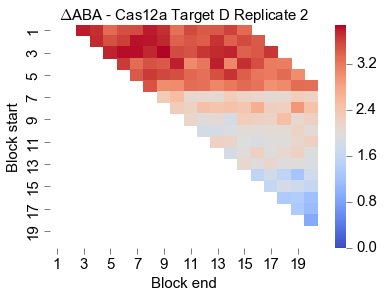

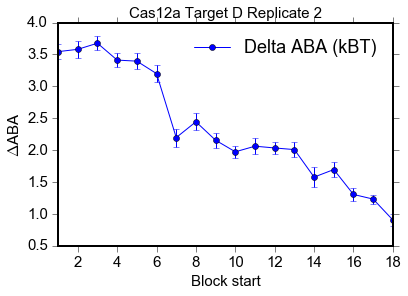

In [20]:
_, _, _, = plot_block_mm_ABA(data, data_name)

### Noncanonical PAM

C:\Users\behro\Anaconda2\lib\site-packages\matplotlib\axes\_base.py:2787: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1.0, right=1.0
  'left=%s, right=%s') % (left, right))


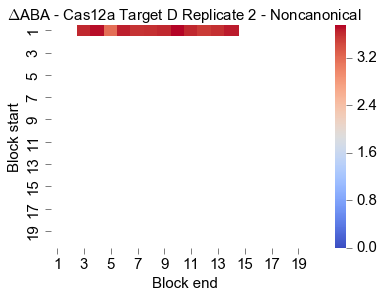

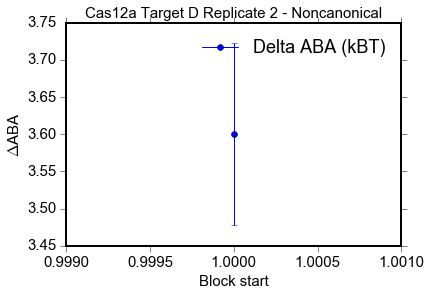

In [21]:
_, _, _, = plot_block_mm_ABA(data, data_name, Canonical=False)

## 4. PAM Mutations

In [22]:
def plot_mut_PAM_ABA(data, data_name='Finkelstein Data'):
    
    NonCanonical = data[(data['Canonical']==False)&(data['Alignment']!='')&(data['Mutation Type']=='')][['PAM', 'Delta ABA (kBT)', 'Uncertainty']].groupby('PAM').mean()
    plt.figure(figsize=(12,6))
    plt.bar(np.arange(len(NonCanonical)), NonCanonical['Delta ABA (kBT)'])
    ax = plt.gca()
    ax.set_xticks(np.arange(len(NonCanonical))+0.5);
    ax.set_xticklabels(NonCanonical.index, rotation='vertical');
    plt.xlabel('PAM', fontsize=15)
    plt.ylabel('$\Delta$ABA', fontsize=15)
    plt.title(data_name,fontsize=15)
    
    return NonCanonical

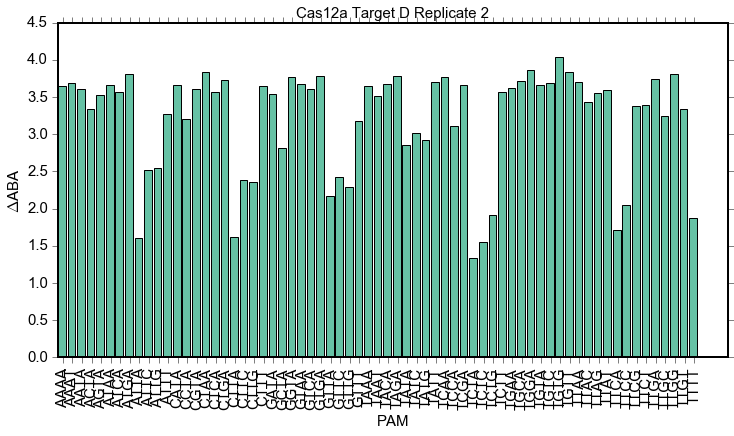

In [23]:
_ = plot_mut_PAM_ABA(data, data_name)

In [24]:
def PAM_in_Seq(S, Cas='Cas9'):
    if Cas == 'Cas9':
        PAM_list = ['AGG', 'CGG', 'GGG', 'TGG']
    if Cas == 'Cas12a':
        PAM_list = ['TTTA', 'TTTC', 'TTTG']
    PAM_exists = map(lambda x: x in S, PAM_list)
    return np.any(np.array(PAM_exists)==True)

Below are the sequences which do not contain a PAM anywhere.

In [25]:
data[data['Sequence'].apply(lambda S: not PAM_in_Seq(S, Cas='Cas9'))]

,Sequence,On Target,PAM,Canonical,Length difference,Alignment,Alignment (All),Mutation ID,Mutation Type,Mutation Count,Delta ABA (kBT),Uncertainty
52,TTTAGTGATAAGTGAGAATGCCATGTGCG,False,TTTA,True,2,GTGATAAGTG-GAATGCCATG-\n|||||||||| |||||||||| ...,GTGATAAGTG-GAATGCCATG-\n|||||||||| |||||||||| ...,i:11:A,i,1.0,2.015637,0.092752
84,TTTAGTGATAAGTGCAATGCCATGTAG,False,TTTA,True,0,GTGATAAGTGGAATGCCATG\n||||||||||.|||||||||\nGT...,GTGATAAGTGG-AATGCCATG\n||||||||| | |||||||||\n...,r:11:C,r,1.0,1.735972,0.052306
344,TTTAGTGATAAGTGAGAATGCCATGTGAG,False,TTTA,True,2,GTGATAAGTG-GAATGCCATG-\n|||||||||| |||||||||| ...,GTGATAAGTG-GAATGCCATG-\n|||||||||| |||||||||| ...,i:11:A,i,1.0,1.813257,0.095745
373,TTTAGTGATAAGTGCAATGCCATGTCG,False,TTTA,True,0,GTGATAAGTGGAATGCCATG\n||||||||||.|||||||||\nGT...,GTGATAAGTGG-AATGCCATG\n||||||||| | |||||||||\n...,r:11:C,r,1.0,1.902421,0.116210
502,TTTAGTGATAAGTAGAATGCCATGTGA,False,TTTA,True,0,GTGATAAGTGGAATGCCATG\n|||||||||.||||||||||\nGT...,GTGATAAGTG-GAATGCCATG\n||||||||| ||||||||||\n...,r:10:A,r,1.0,0.908101,0.089633
503,TTTAGTGATAAGTAGAATGCCATGTGC,False,TTTA,True,0,GTGATAAGTGGAATGCCATG\n|||||||||.||||||||||\nGT...,GTGATAAGTG-GAATGCCATG\n||||||||| ||||||||||\n...,r:10:A,r,1.0,0.834449,0.043418
508,TTTAGTGATAAGTAGAATGCCATGTGT,False,TTTA,True,0,GTGATAAGTGGAATGCCATG\n|||||||||.||||||||||\nGT...,GTGATAAGTG-GAATGCCATG\n||||||||| ||||||||||\n...,r:10:A,r,1.0,0.729436,0.058504
993,TTTAGTGATAAGTTGAATGCCATGTGT,False,TTTA,True,0,GTGATAAGTGGAATGCCATG\n|||||||||.||||||||||\nGT...,GTGATAAGTG-GAATGCCATG\n||||||||| ||||||||||\n...,r:10:T,r,1.0,1.951055,0.072670
997,TTTAGTGATAAGTTGAATGCCATGTGA,False,TTTA,True,0,GTGATAAGTGGAATGCCATG\n|||||||||.||||||||||\nGT...,GTGATAAGTG-GAATGCCATG\n||||||||| ||||||||||\n...,r:10:T,r,1.0,1.931370,0.151688
1312,TTTAGTGATAAGTAGAATGCCATGTAG,False,TTTA,True,0,GTGATAAGTGGAATGCCATG\n|||||||||.||||||||||\nGT...,GTGATAAGTG-GAATGCCATG\n||||||||| ||||||||||\n...,r:10:A,r,1.0,0.656401,0.051060


## 5. Nonspecific Binding

In [26]:
data[data['Length difference']==8]

,Sequence,On Target,PAM,Canonical,Length difference,Alignment,Alignment (All),Mutation ID,Mutation Type,Mutation Count,Delta ABA (kBT),Uncertainty
1084,AAGTCGGCTCCTGTTTAGTTACGAGCGACATTGCT,False,AAGT,False,8,,-G--T---GATA--AGTGG-A--ATGC--CATG-\n | | | ...,,,NaN,3.597918,0.019865
3312,AAGGCCGAATTCTCACCGGCCCCAAGGTATTCAAG,False,AAGG,False,8,,GT--GATAAGT-------GG----AATGCC--ATG--\n | ...,,,NaN,3.689420,0.018577
4509,ACCGCCGAATTCTCACCGGCCCCAAGGTATTCAAG,False,ACCG,False,8,,GT--GATAAGT-------GG----AATGCC--ATG--\n | ...,,,NaN,3.685877,0.014970
7150,AAGCCAGTGATAAGTGGAATGCCATGTGGGCTGTC,False,AAGC,False,8,--GTGATAAGTGGAATGCCATG------\n ||||||||||||||...,--GTGATAAGTGGAATGCCATG------\n ||||||||||||||...,i:1:C|i:1:A,i|i,2.0,3.631758,0.016855


In [27]:
on_target

'TTTAGTGATAAGTGGAATGCCATGTGG'